###### this notebook compares the performance of different models on the dataset. The models used are:
###### 1. LSTM (Long Short Term Memory)
###### 2. ARIMA (AutoRegressive Integrated Moving Average)
###### 3. Prophet

###### Libraries used:

In [1]:
import pandas
import math
import yfinance as yf
import numpy as np
import pandas as pd
import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

2025-02-02 19:28:44.930064: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-02 19:28:44.948440: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-02 19:28:44.954915: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-02 19:28:44.969963: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-02 19:28:46.140732: W tensorflow/compiler/tf2

In [2]:
!nvidia-smi

Sun Feb  2 19:28:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.51.01              Driver Version: 565.90         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080        On  |   00000000:09:00.0  On |                  N/A |
|  0%   51C    P8             44W /  320W |     730MiB /  10240MiB |     26%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

###### Get stock data from yahoo finance

In [3]:
## Get the APPLE stock data
start = datetime.datetime(1979, 1, 1)
end = datetime.datetime(2024, 12, 31)

def get_stock_data(stock_name, start_date, end_date):
    return yf.download(stock_name, start=start_date, end=end_date, progress=False)

historical_apple = get_stock_data('AAPL', start, end)
historical_apple

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.098834,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.093678,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.086802,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.088951,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.091530,73449600
...,...,...,...,...,...,...
2024-12-23,254.770004,255.649994,253.449997,255.270004,255.270004,40858800
2024-12-24,255.490005,258.209991,255.289993,258.200012,258.200012,23234700
2024-12-26,258.190002,260.100006,257.630005,259.019989,259.019989,27237100


In [4]:
print(historical_apple.head())
print(historical_apple.shape)

                Open      High       Low     Close  Adj Close     Volume
Date                                                                    
1980-12-12  0.128348  0.128906  0.128348  0.128348   0.098834  469033600
1980-12-15  0.122210  0.122210  0.121652  0.121652   0.093678  175884800
1980-12-16  0.113281  0.113281  0.112723  0.112723   0.086802  105728000
1980-12-17  0.115513  0.116071  0.115513  0.115513   0.088951   86441600
1980-12-18  0.118862  0.119420  0.118862  0.118862   0.091530   73449600
(11104, 6)


###### Data manipulation and visualization
###### creating a time series model using the rolling mean with different window sizes
###### The rolling(window=...) method is used to calculate the rolling mean (moving average) of the 'Close' prices over the specified window sizes (10, 20, 30, and 40 days).
###### The mean() method computes the average of the values within each rolling window.



###### Purpose:
###### Smoothing the Data: Rolling means are used to smooth out short-term fluctuations and highlight longer-term trends or cycles in the data.
###### Feature Engineering: These rolling mean values can be used as additional features in machine learning models to predict future stock prices.

In [5]:
rolling_df = pd.DataFrame()

def create_moving_average(data, features, window):
    return data[features].rolling(window=window).mean()

rolling_df['Close'] = historical_apple['Close']

for i in range(10, 41, 10):
    rolling_df['close' + str(i)] = create_moving_average(historical_apple, 'Close', i)

In [6]:
rolling_df

,Close,close10,close20,close30,close40
Date,,,,,
1980-12-12,0.128348,NaN,NaN,NaN,NaN
1980-12-15,0.121652,NaN,NaN,NaN,NaN
1980-12-16,0.112723,NaN,NaN,NaN,NaN
1980-12-17,0.115513,NaN,NaN,NaN,NaN
1980-12-18,0.118862,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2024-12-23,255.270004,250.247002,245.026999,239.034332,235.990999
2024-12-24,258.200012,251.290002,246.293500,240.166666,236.611000
2024-12-26,259.019989,252.543001,247.491499,241.326333,237.244749


In [7]:
def plot_historical_data_lag(data, window):
    plt.figure(figsize=(20,10))
    plt.plot(historical_apple['Close'].tail(200), label='Close Price')

    for i in range(10, window + 1, 10):
        plt.plot(data['close' + str(i)].tail(200), label='close' + str(i))
    
    plt.title('Apple Close Price History')
    plt.xlabel('Jan. 01, 2012 - Dec. 17, 2019')
    plt.ylabel('Close Price USD($)')
    plt.legend(loc='upper left')
    plt.show()

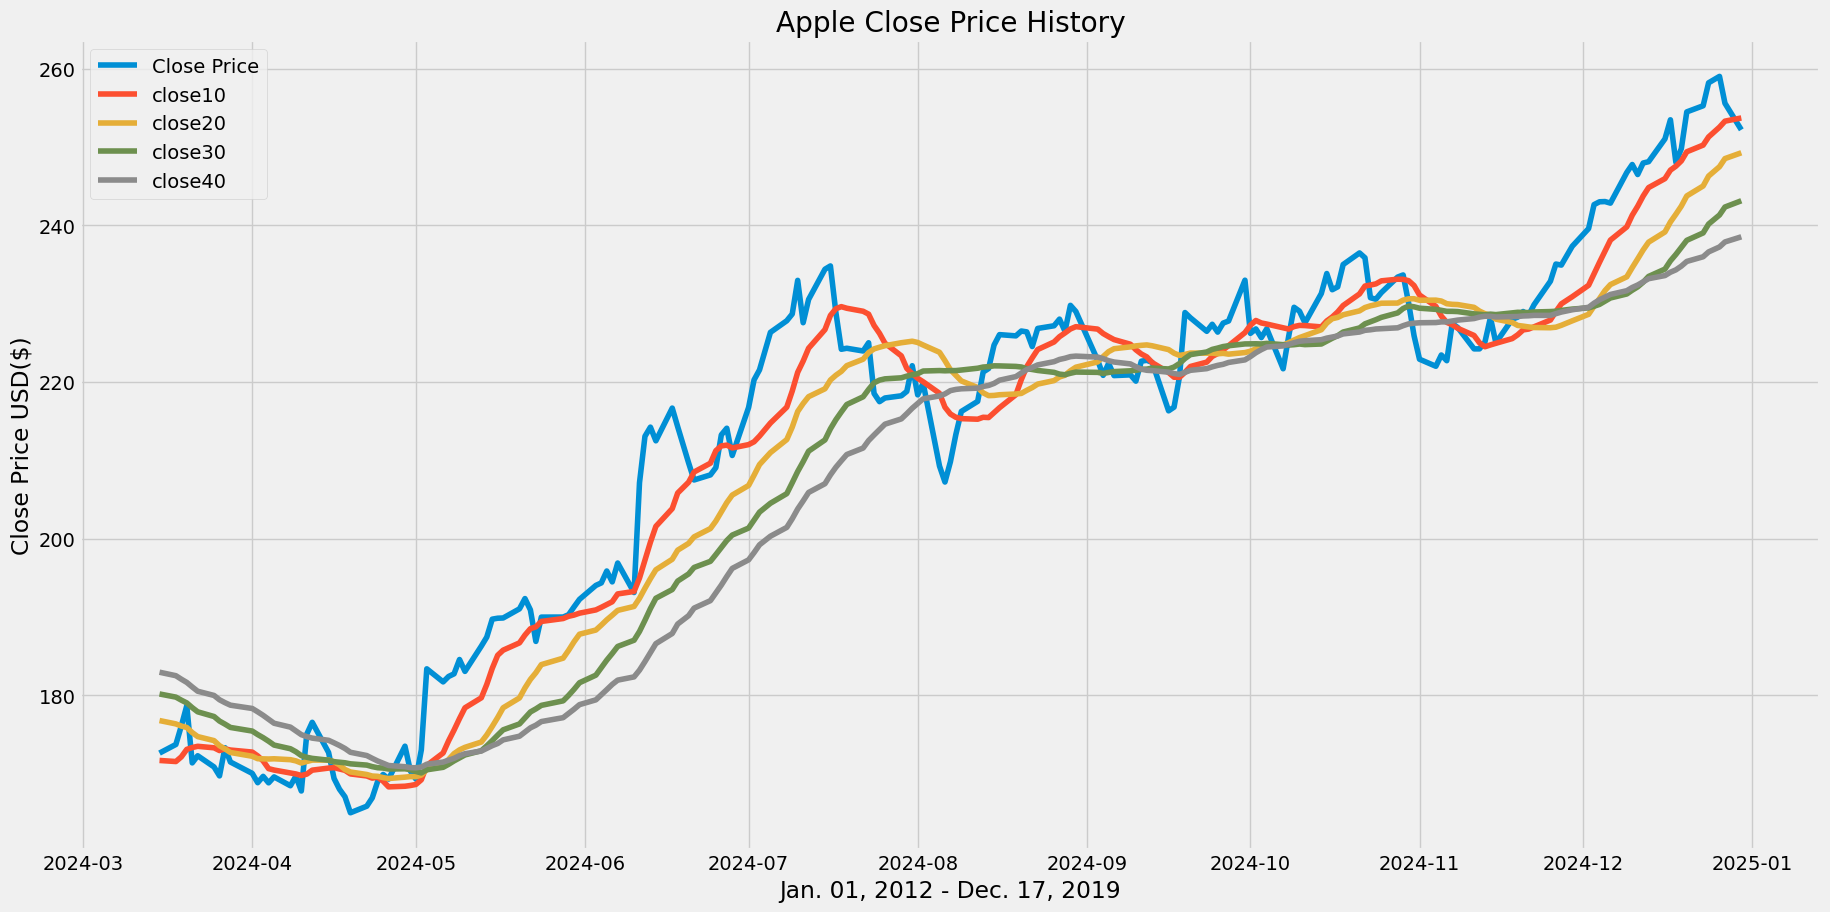

In [8]:
plot_historical_data_lag(rolling_df, 40)

###### Filter the close price data to include only the 'Date' and 'Close' columns.
###### Set the 'Date' column as the index of the DataFrame.
###### Plot the 'Close' prices of the stock over time.

In [9]:
# Create a new dataframe with only the 'Close column
values_at_close_data = historical_apple.filter(['Close'])
values_at_close_data.head()

,Close
Date,
1980-12-12,0.128348
1980-12-15,0.121652
1980-12-16,0.112723
1980-12-17,0.115513
1980-12-18,0.118862


In [10]:
#Convert the dataframe to a numpy array
values_at_close_np = values_at_close_data.values

######

In [11]:
#Get the number of rows to train the model on keeping 80% of the data
training_data_len = math.ceil(len(values_at_close_np)*.8)
training_data_len

8884

###### Scale the data using MinMaxScaler from sklearn.preprocessing.
###### Normalization: Scaling the data to a range of 0 to 1 helps in normalizing the data, which can improve the performance and convergence speed of many machine learning algorithms.
###### Consistency: Ensures that all features contribute equally to the model, preventing features with larger ranges from dominating the learning process.

In [12]:
def data_scaler(data, scaler):
    scaler = MinMaxScaler()#feature_range=(0,1))
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaled_data.shape

scaled_data, scaled_data_shape = data_scaler(values_at_close_np, MinMaxScaler())
print(scaled_data)
print(scaled_data_shape)

[[3.05984179e-04]
 [2.80128016e-04]
 [2.45649239e-04]
 ...
 [1.00000000e+00]
 [9.86755296e-01]
 [9.73665024e-01]]
(11104, 1)


In [13]:
def create_training_features(data, training_data_len):
    train_data = data[0:training_data_len,:]
    x_train = []

    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i,0])
        if i<=61:
            print(x_train)
            print()
    return x_train

def create_training_labels(data, training_data_len):
    y_train = []
    train_data = data[0:training_data_len,:]
    for i in range(60, len(train_data)):
        y_train.append(train_data[i,0])
        if i<=61:
            print(y_train)
            print()
    return y_train

x_train = create_training_features(scaled_data, training_data_len)
y_train = create_training_labels(scaled_data, training_data_len)

#print(x_train)
#print(y_train)

print(len(x_train))
print(len(y_train))

[array([0.00030598, 0.00028013, 0.00024565, 0.00025642, 0.00026935,
       0.00029737, 0.00032107, 0.00034262, 0.00037063, 0.00042234,
       0.00043096, 0.00041588, 0.00039864, 0.00040511, 0.00039218,
       0.00036632, 0.00034262, 0.00033184, 0.00035986, 0.00035555,
       0.00033615, 0.00033831, 0.00034908, 0.00034477, 0.00037709,
       0.00035986, 0.00037063, 0.00037709, 0.00037494, 0.00036632,
       0.00036201, 0.00034477, 0.00032538, 0.00029737, 0.00026935,
       0.00028659, 0.00030383, 0.00030383, 0.00030598, 0.00028013,
       0.00028013, 0.00026505, 0.00026073, 0.00024996, 0.00026073,
       0.00028013, 0.00025211, 0.00022841, 0.00023488, 0.00021979,
       0.00024565, 0.00025211, 0.0002672 , 0.00026935, 0.00026289,
       0.00025858, 0.00025642, 0.00025211, 0.00021764, 0.00019824])]

[array([0.00030598, 0.00028013, 0.00024565, 0.00025642, 0.00026935,
       0.00029737, 0.00032107, 0.00034262, 0.00037063, 0.00042234,
       0.00043096, 0.00041588, 0.00039864, 0.00040511, 0.

In [14]:
def preprocess_training_data(x_train, y_train):
    #Convert the x_train and y_train to numpy array
    x_train, y_train = np.array(x_train), np.array(y_train)
    #Reshape the data
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    return x_train, y_train

In [15]:
x_train, y_train = preprocess_training_data(x_train, y_train)
print(x_train.shape)
print(y_train.shape)

(8824, 60, 1)
(8824,)


In [16]:
def LSTM_model():
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    return model


In [17]:
lstm_model = LSTM_model()

I0000 00:00:1738542529.212176 1418026 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1738542529.488129 1418026 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1738542529.488210 1418026 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1738542529.492068 1418026 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1738542529.492182 1418026 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [18]:
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

In [19]:
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Train the model using the GPU
import tensorflow as tf

# get the GPU device name
device_name = tf.test.gpu_device_name()

# check device is available
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


I0000 00:00:1738542531.713814 1418026 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1738542531.713921 1418026 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1738542531.713968 1418026 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1738542531.714237 1418026 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-02 19:28:51.714256: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2112] Could not identify NUMA node of platform GPU id 0, defaulting to 0.  Your kernel may not have been built with NUMA support.

In [21]:
with tf.device('/device:GPU:0'):
  lstm_model.fit(x_train, y_train, batch_size=1, epochs=5)

Epoch 1/5


2025-02-02 19:28:54.504366: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


8824/8824 ━━━━━━━━━━━━━━━━━━━━ 157s 17ms/step - loss: 4.6249e-05
Epoch 2/5
8824/8824 ━━━━━━━━━━━━━━━━━━━━ 159s 18ms/step - loss: 6.8812e-06
Epoch 3/5
8824/8824 ━━━━━━━━━━━━━━━━━━━━ 158s 18ms/step - loss: 5.1260e-06
Epoch 4/5
8824/8824 ━━━━━━━━━━━━━━━━━━━━ 149s 17ms/step - loss: 3.3680e-06
Epoch 5/5
8824/8824 ━━━━━━━━━━━━━━━━━━━━ 156s 18ms/step - loss: 3.1349e-06


###### Inference

In [32]:
def create_testing_features(data, training_data_len):
    test_data = data[training_data_len-60:, :]
    x_test = []
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i,0])
    return x_test

def create_testing_labels(data, training_data_len):
    y_test = data[training_data_len:, :]
    return y_test

x_test, y_test = create_testing_features(scaled_data, training_data_len), create_testing_labels(values_at_close_np, training_data_len)

In [33]:
def preprocess_testing_data(x_test, y_test):
    #Convert the x_train and y_train to numpy array
    x_test, y_test = np.array(x_test), np.array(y_test)
    #Reshape the data
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    return x_test, y_test

x_test, y_test = preprocess_testing_data(x_test, y_test)
print(x_test.shape)
print(y_test.shape)

(2220, 60, 1)
(2220, 1)


In [34]:
# Get the model predicted price values
predictions = lstm_model.predict(x_test)
predictions = MinMaxScaler().fit(values_at_close_np).inverse_transform(predictions)

70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [35]:
print(predictions[0:5], y_test[0:5])

[[24.553415]
 [24.18788 ]
 [24.073061]
 [24.14554 ]
 [24.163324]] [[25.46750069]
 [25.25749969]
 [25.28000069]
 [25.29249954]
 [25.56500053]]


In [36]:
# Get the MSE & RMSE
mse = np.mean(predictions-y_test)**2
rmse = np.sqrt(np.mean(predictions-y_test)**2)
mse, rmse

(224.87053561196245, 14.99568389944128)

In [37]:
#train = data[:training_data_len]
#valid = data[training_data_len:]

train = values_at_close_data[:training_data_len]
valid = values_at_close_data[training_data_len:]

valid['Predictions'] = predictions

def plot_predictions(data):
    plt.figure(figsize=(16,8))
    plt.title('Model')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.plot(data['Close'])
    plt.plot(data[['Close','Predictions']])
    plt.legend(['True', 'Val', 'Predictions'], loc = 'lower right')
    plt.show()

/tmp/ipykernel_1418026/508438265.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


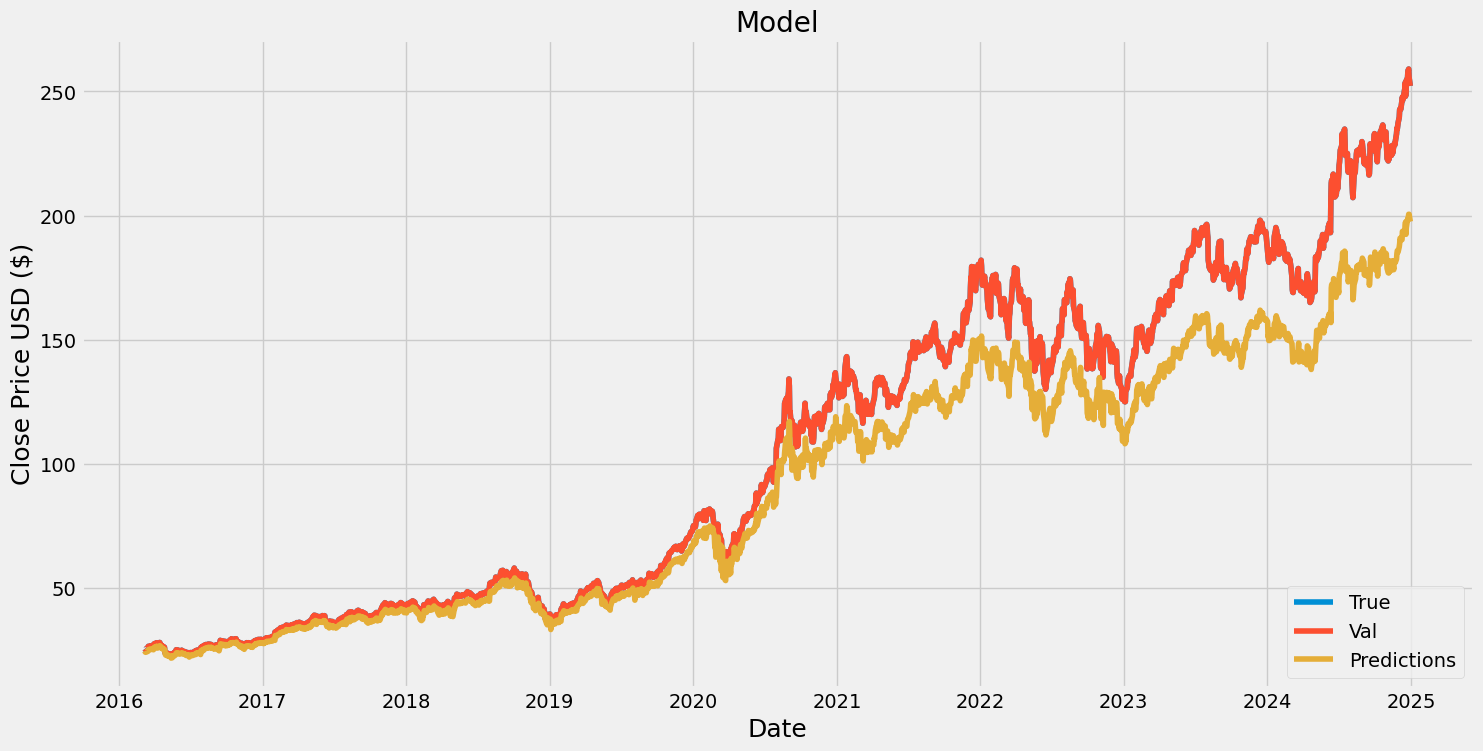

In [38]:
plot_predictions(valid)

In [43]:
# Get the quote
apple_quote = yf.download('AAPL', start='2025-01-05', end='2025-01-07', progress=False)
#Create a new dataframe
new_df = apple_quote.filter(['Close'])
# Get the last 60 day closing price values and convert the dataframe to an array
last_60_days = new_df[-60:].values
#Scale the data to be values between 0 and 1
#last_60_days_scaled = scaler.transform(last_60_days)
last_60_days_scaled = MinMaxScaler().fit(values_at_close_np).transform(last_60_days)



#Create an empty list
X_test = []
#Append the past 60 day 
X_test.append(last_60_days_scaled)
#Convert the X_test data set to a numpy array
X_test = np.array(X_test)
#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
# Get the predicted scaled price
prediction_price = lstm_model.predict(X_test)
#Undo the scaling
prediction_price = MinMaxScaler().fit(values_at_close_np).inverse_transform(prediction_price)
print(prediction_price)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[[201.27548]]


In [44]:
# Get the quote
apple_quote2 = yf.download('AAPL', start='2025-01-05', end='2025-01-7', progress=False)
apple_quote2

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2025-01-06,244.309998,247.330002,243.199997,245.0,245.0,45045600
